<h1> Предсказание оттока пользователей <span class="tocSkip"></span></h1>

<h1> Задача: <span class="tocSkip"></span></h1>

Датасет: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

По имеющимся числовым и категориальным признакам необходимо спрогнозировать факт ухода клинета из телеком компании.

# Исследовательский анализ данных

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

!pip install termcolor
from termcolor import colored

!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

!pip install pandas-visual-analysis
from pandas_visual_analysis import VisualAnalysis

# установим фиксированный размер наших графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,  make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

!pip install catboost
from catboost import CatBoostClassifier

# для того, чтобы не засорять вывод предупреждениями
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00


## Загрузка данных 



In [ ]:
df = pd.read_csv('./train.csv')

In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Посмотрим информацию о датасете. 


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Вроде бы все нормально, пропусков нет, однако смущает то, что количественный признак 'TotalSpent' имеет тип object. Значит там есть строковые значения.

## Анализ данных и визуализация

In [ ]:
df[df['TotalSpent'] ==' '] 

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [ ]:
len(df[df['TotalSpent'] ==' '])

9

Видим, что это клиенты, с ClientPeriod равным нулю и всего 9 человек - не так много. Заменим эти значения на 0.

In [ ]:
df['TotalSpent'].replace(' ', 0, inplace=True)

Приведем столбец TotalSpent к типу float.

In [ ]:
df['TotalSpent'] = df['TotalSpent'].astype('float')

Проверим снова информацию о датасете.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

### Числовые признаки 

Напишем функцию для построения гистограмм. 

In [ ]:
def hist (col):
    plt.hist(df[col])
    plt.title(f'Гистограмма распределения {col}')
    plt.show()

Выведем гистограммы распределений числовых признаков.

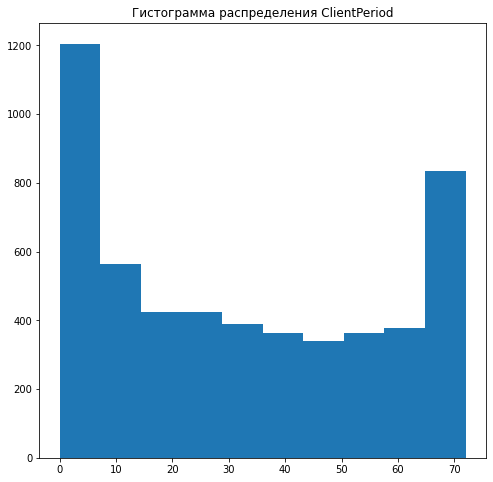

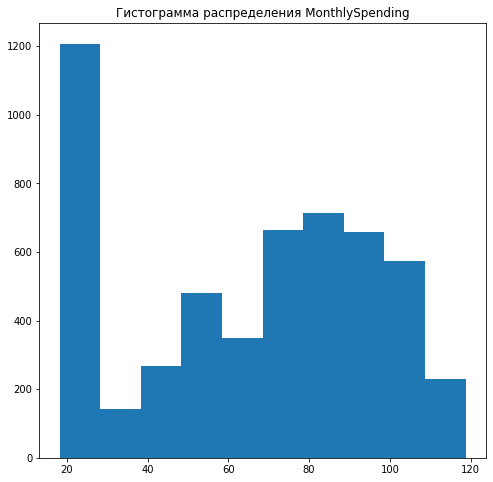

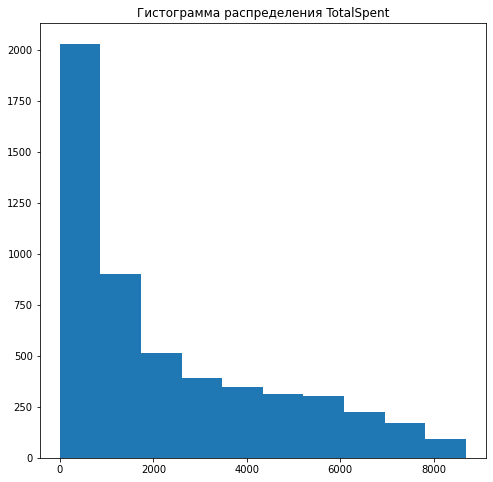

In [ ]:
for i in num_cols:
    hist(i)

Построим ящики с усами для числовых столбцов на одном графике. 

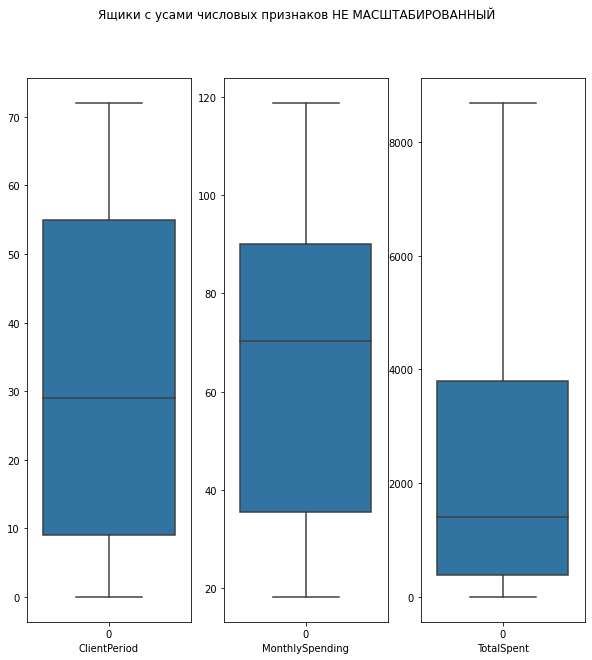

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10)) #, sharey=True)
sns.boxplot(data=df['ClientPeriod'],  ax=ax1) #y='monthly_charges',
sns.boxplot(data=df['MonthlySpending'], ax=ax2) #y='monthly_charges', 
sns.boxplot(data=df['TotalSpent'], ax=ax3) #y='monthly_charges', 

ax1.set_xlabel('ClientPeriod'), ax1.set_ylabel('')
ax2.set_xlabel('MonthlySpending'), ax2.set_ylabel('')
ax3.set_xlabel('TotalSpent'), ax3.set_ylabel('')

plt.suptitle('Ящики с усами числовых признаков НЕ МАСШТАБИРОВАННЫЙ')
plt.show()


Выбросов не видим. 

### Категориальные признаки

Построим на одном графике столбчатые диаграммы распределения категориальных признаков. 

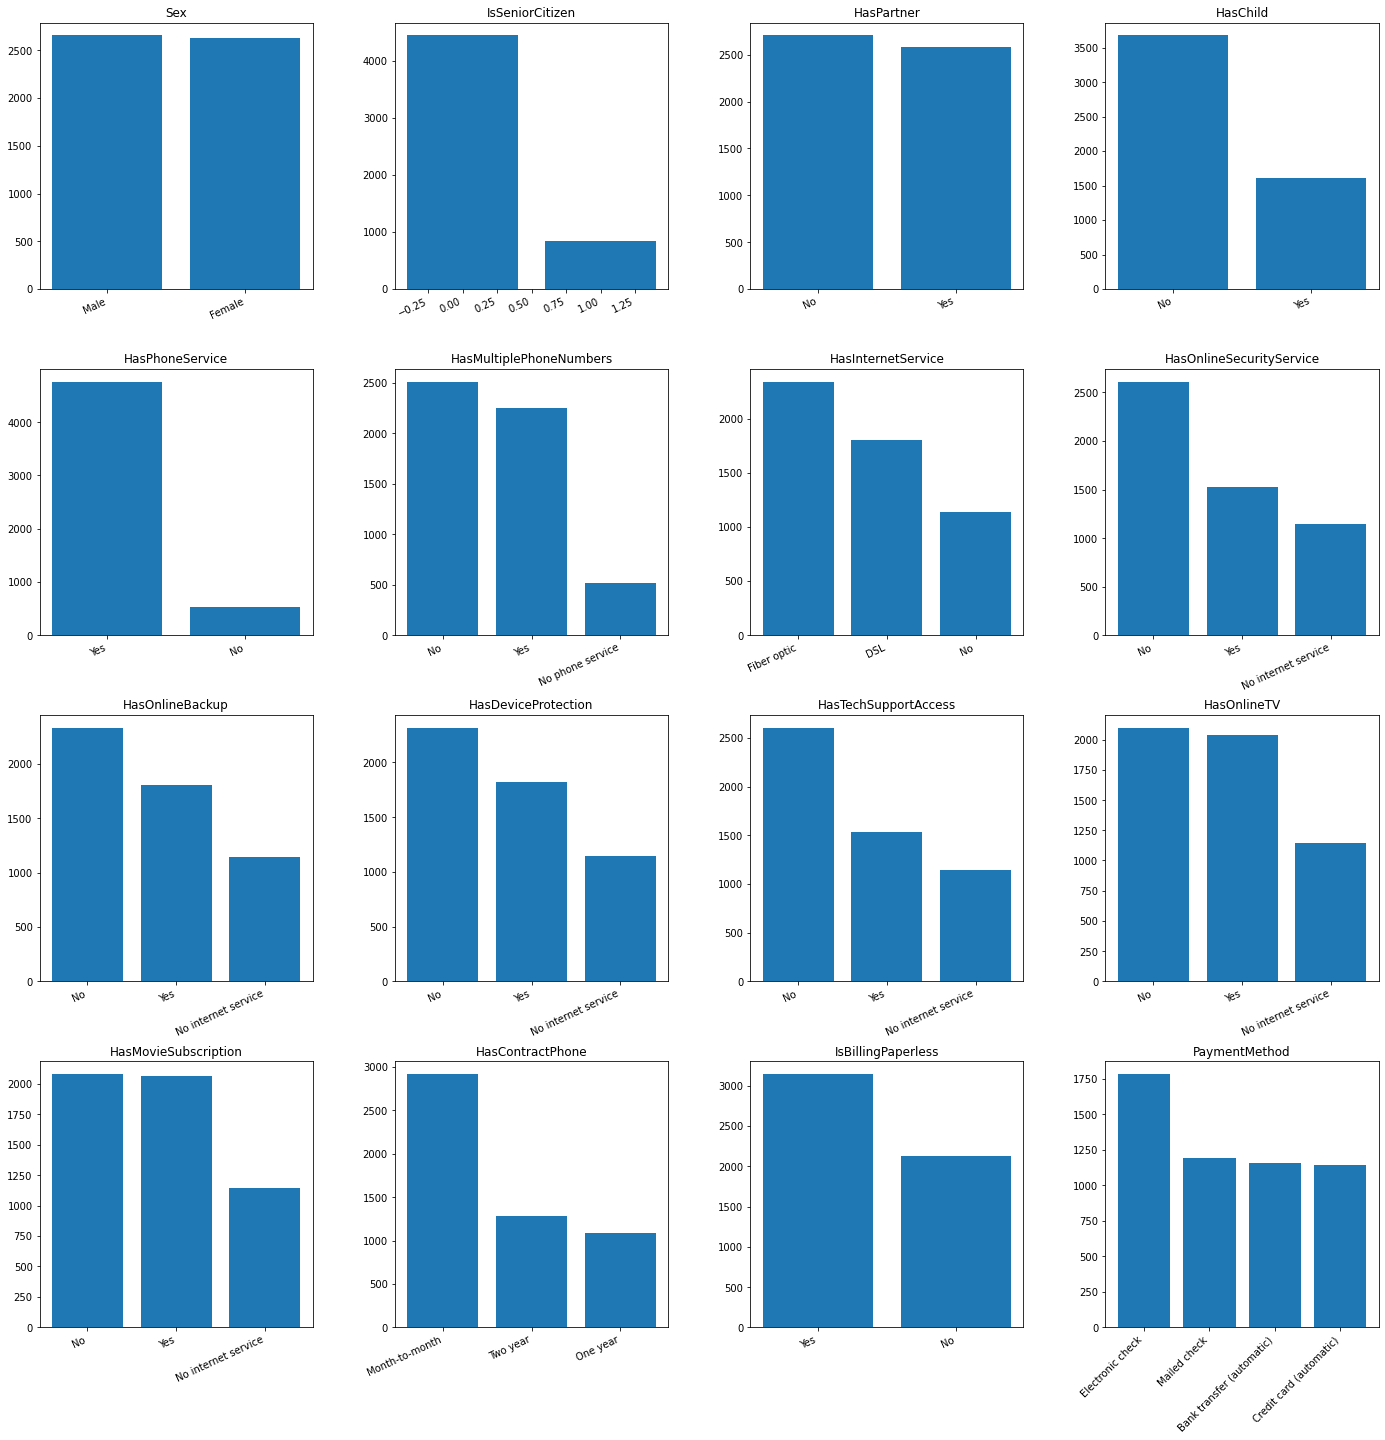

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(24,24))

ax = ax.ravel()
j = 0
for i in cat_cols:
    
    ax[j].set_title(f'{i}')
    ax[j].bar(x = df[i].value_counts().index, height = df[i].value_counts().values)
                  
    labels = ax[j].get_xticklabels()
    plt.setp(labels, rotation = 25, horizontalalignment = 'right')
    plt.xticks(rotation=45) 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    j +=1
    
fig.show()

Выведем df.value_counts() для всех категориальных признаков. 

In [ ]:
for i in cat_cols:
    print(colored(i, 'red', attrs=['bold']))
    print(df[i].value_counts())
    print('\n')
    

Sex
Male      2655
Female    2627
Name: Sex, dtype: int64


IsSeniorCitizen
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64


HasPartner
No     2705
Yes    2577
Name: HasPartner, dtype: int64


HasChild
No     3676
Yes    1606
Name: HasChild, dtype: int64


HasPhoneService
Yes    4761
No      521
Name: HasPhoneService, dtype: int64


HasMultiplePhoneNumbers
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


HasInternetService
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64


HasOnlineSecurityService
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64


HasOnlineBackup
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64


HasDeviceProtection
No                     2317
Yes                    1824
No internet service  

### Распределение целевого признака

In [ ]:
df['Churn']

0       0
1       0
2       1
3       0
4       0
       ..
5277    0
5278    0
5279    0
5280    0
5281    0
Name: Churn, Length: 5282, dtype: int64

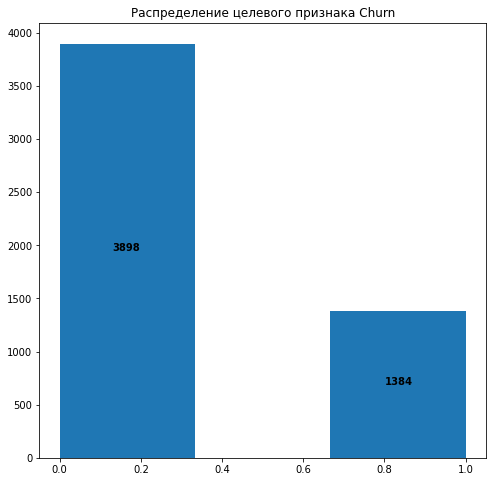

In [ ]:
plt.hist(df['Churn'], bins = 3)
plt.title('Распределение целевого признака Churn')
plt.text(0.13, df['Churn'].value_counts()[0]/2, df['Churn'].value_counts()[0], color='black', fontweight='bold')
plt.text(0.80, df['Churn'].value_counts()[1]/2, df['Churn'].value_counts()[1], color='black', fontweight='bold')
plt.show()

Видим, что ушедших в 3 раза меньше, чем оставшихся. Классы несбалансированы, но не критично.

Посмотрим описательные статистики и ящики с усами для ушедших и оставшихся клиентов. 

In [ ]:
df[df['Churn']==1].describe().round(3)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,1384.000,1384.000,1384.000,1384.000,1384.0
mean,17.952,74.281,1525.832,0.256,1.0
std,19.460,24.551,1881.443,0.436,0.0
min,1.000,18.950,19.100,0.000,1.0
25%,2.000,56.438,134.650,0.000,1.0
50%,10.000,79.500,706.725,0.000,1.0
75%,29.000,94.200,2352.550,1.000,1.0
max,72.000,118.350,8684.800,1.000,1.0


In [ ]:
df[df['Churn']==0].describe().round(3)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,3898.000,3898.000,3898.000,3898.000,3898.0
mean,37.526,61.603,2557.914,0.125,0.0
std,24.124,31.273,2332.736,0.331,0.0
min,0.000,18.250,0.000,0.000,0.0
25%,15.000,25.100,564.462,0.000,0.0
50%,37.000,64.775,1709.125,0.000,0.0
75%,61.000,89.100,4273.600,0.000,0.0
max,72.000,118.750,8672.450,1.000,0.0


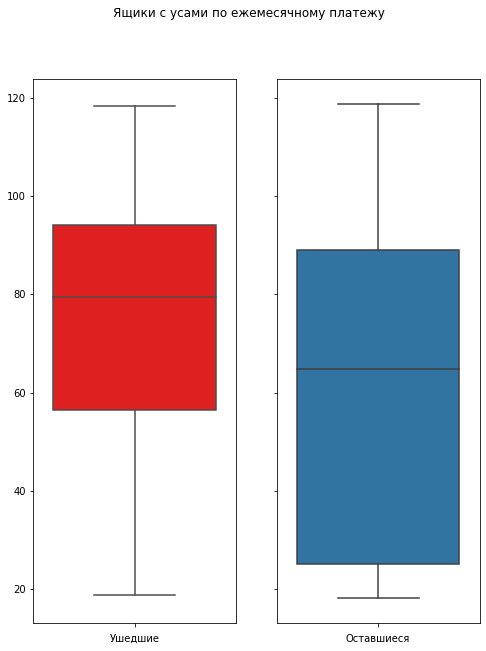

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
sns.boxplot(data=df[df['Churn']==1], y='MonthlySpending', ax=ax1, color = 'red')
sns.boxplot(data=df[df['Churn']==0], y='MonthlySpending', ax=ax2)

ax1.set_xlabel('Ушедшие'), ax1.set_ylabel('')
ax2.set_xlabel('Оставшиеся'), ax2.set_ylabel('')
plt.suptitle('Ящики с усами по ежемесячному платежу')
plt.show()

Выбросов не обнаружено. Но можно видеть, что среднее значение платежа у ушедших больше. Также можно отметить, что у оставшихся разброс значений платежа большой, в то время, как у ушедщих значения ежемесячного платежа более компактны. 

Посмотрим расброс продолжительности жизни клиентов. 

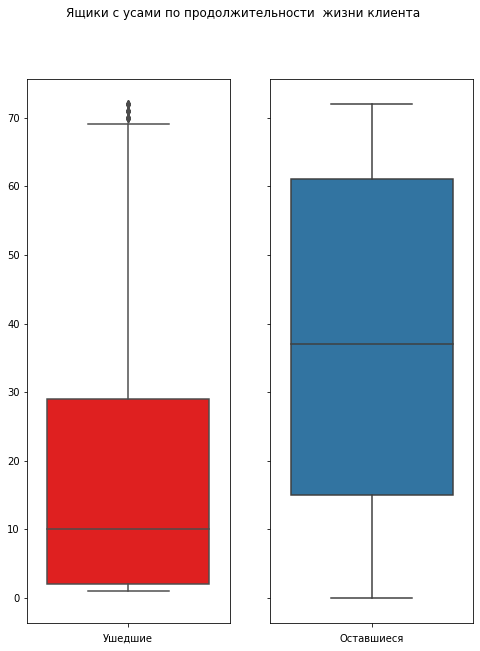

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
sns.boxplot(data=df[df['Churn']==1], y='ClientPeriod', ax=ax1, color = 'red')
sns.boxplot(data=df[df['Churn']==0], y='ClientPeriod', ax=ax2)

ax1.set_xlabel('Ушедшие'), ax1.set_ylabel('')
ax2.set_xlabel('Оставшиеся'), ax2.set_ylabel('')
plt.suptitle('Ящики с усами по продолжительности  жизни клиента')
plt.show()

Посмотрим на выбросы, то есть на ушедших клиентов, продолжительность жизни которых больше 68 дней. 

In [ ]:
df[(df['Churn']==1)&(df['ClientPeriod']>=68)]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
246,68,108.45,7176.55,Male,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check,1
473,69,78.60,5356.45,Male,0,No,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,One year,Yes,Credit card (automatic),1
506,70,115.65,7968.85,Male,0,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),1
565,70,65.30,4759.75,Female,0,Yes,No,Yes,Yes,DSL,Yes,No,Yes,Yes,No,No,Two year,No,Credit card (automatic),1
927,70,109.50,7674.55,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,1
1160,69,99.45,7007.60,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),1
1263,72,109.25,8109.80,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,1
1415,71,108.05,7532.15,Male,0,No,No,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,1
1537,68,110.00,7611.85,Male,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),1
1756,71,106.00,7723.70,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),1


Таких клиентов довольно много, поэтому, не будем их удалять. 

Построим гистограммы платежей у ушедших и оставшихся клиентов. Для этого напишем отдельную функцию.  

In [ ]:
def phist(i, st, text_pay, text_client):
    df[df['Churn']==i][st].hist()
    plt.xlabel( text_pay)
    plt.ylabel('Количество клиентов')
    plt.title(f'Платежи {text_client} клиентов')
    plt.show() 

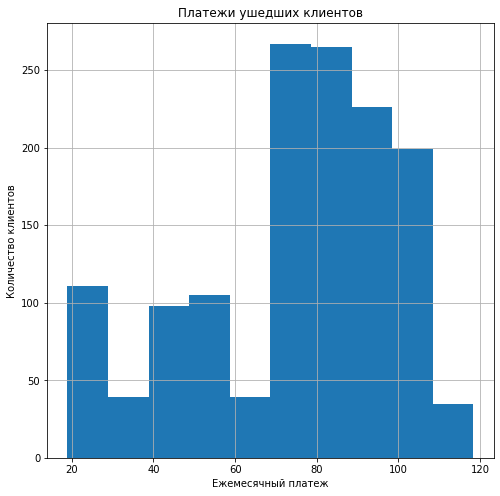

In [ ]:
phist(1, 'MonthlySpending', 'Ежемесячный платеж',  'ушедших')

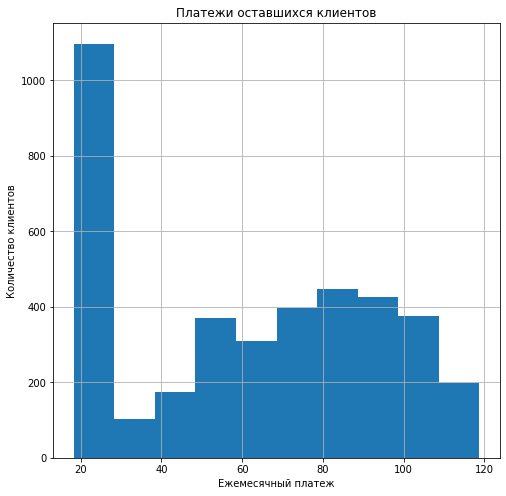

In [ ]:
phist(0, 'MonthlySpending', 'Ежемесячный платеж',  'оставшихся')

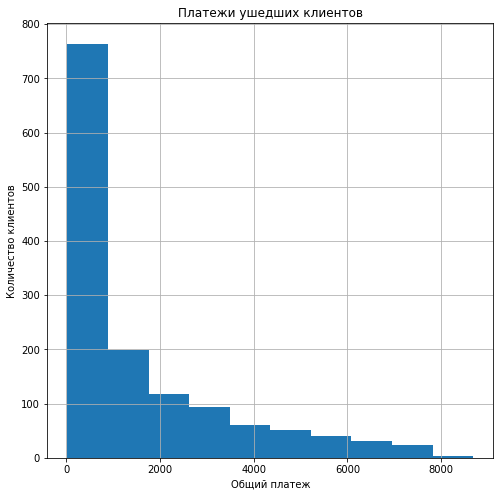

In [ ]:
phist(1, 'TotalSpent', 'Общий платеж',  'ушедших')

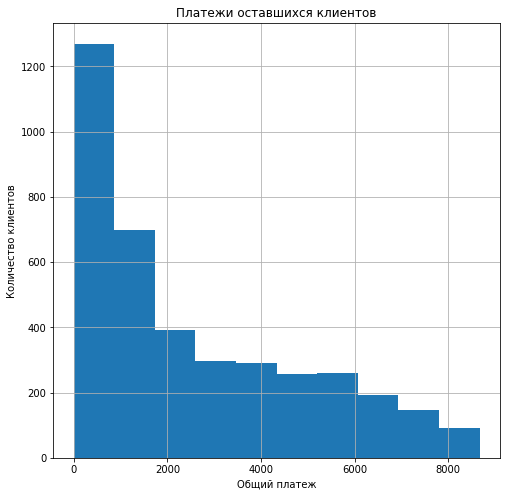

In [ ]:
phist(0, 'TotalSpent', 'Общий платеж',  'оставшихся')

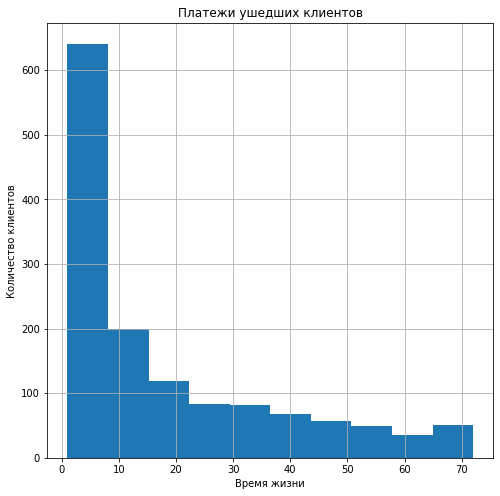

In [ ]:
phist(1, 'ClientPeriod', 'Время жизни',  'ушедших')

Дааа, выходит, клиенты уходят даже в течении первой недели. 

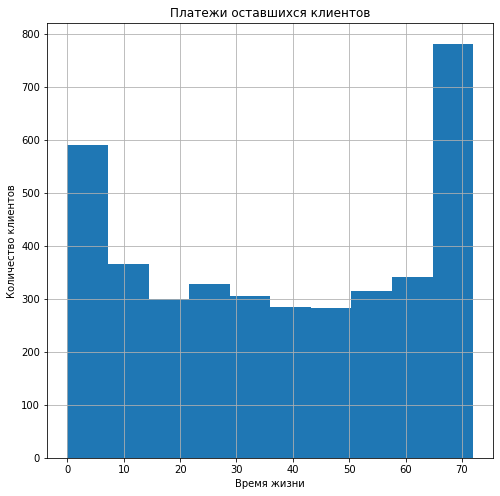

In [ ]:
phist(0, 'ClientPeriod', 'Время жизни',  'оставшихся')

В целом, гистограммы подтвердили наши выводы из ящиков с усами. 

### Pandas_visual_analysis

Посмотрим возможности библиотеки pandas_visual_analysis.

In [ ]:
VisualAnalysis(df) #, categorical_columns=cat_cols)
#VisualAnalysis(df)

Классно упрощает работу! 

### Удаление дубликатов

Удалим дубликаты, если они есть. 

In [ ]:
df = df.drop_duplicates().reset_index(drop = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlin

## Вывод

В данном разделе был произведен небольшой исследовательский анализ данных:
1. очистка от пропусков,
2. выбросов в количественных признаках найдено не было,
3. просмотр распределения данных на числовых и категориальных признаках,
4. просмотр распределения целевой переменной,
8. удаление дубликатов.

Также можно заметить, что средний платеж у ушедших клиентов больше. А продолжительность жизни меньше: очень многие клиенты уходят в течении первой недели. Необходимо как-то их удерживать. Может быть промо акции?

# Предобработка данных перед обучением

## Кодирование категориальных признаков

In [ ]:
df.head(3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1


Так как планируем использовать разные модели для обучения, в том числе и линейные, такие как логистическая регресиия, то нельзя использовать технику OrdinalEncoder. Будеи использовать OHE, убирая первый признак. 

In [ ]:
# сделаем копию датасета для последующего использования в pipeline
df_pipe = df.copy()

In [ ]:
df = pd.get_dummies(df,drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientPeriod                                  5268 non-null   int64  
 1   MonthlySpending                               5268 non-null   float64
 2   TotalSpent                                    5268 non-null   float64
 3   IsSeniorCitizen                               5268 non-null   int64  
 4   Churn                                         5268 non-null   int64  
 5   Sex_Male                                      5268 non-null   uint8  
 6   HasPartner_Yes                                5268 non-null   uint8  
 7   HasChild_Yes                                  5268 non-null   uint8  
 8   HasPhoneService_Yes                           5268 non-null   uint8  
 9   HasMultiplePhoneNumbers_No phone service      5268 non-null   u

## Проверка признаков на взаимную корреляцию

In [ ]:
features = df.drop(['Churn'], axis=1)
target = df['Churn']

Проверим, есть ли корреляция между признаками. Будем смотреть на коэффициент Phik.

In [ ]:
features.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,...,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,1,1,1,1,0,0,...,1,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,1,1,0,1,0,1,...,1,0,1,0,0,1,0,1,0,0


In [ ]:
interval_cols = ['MonthlySpending', 'TotalSpent','ClientPeriod']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

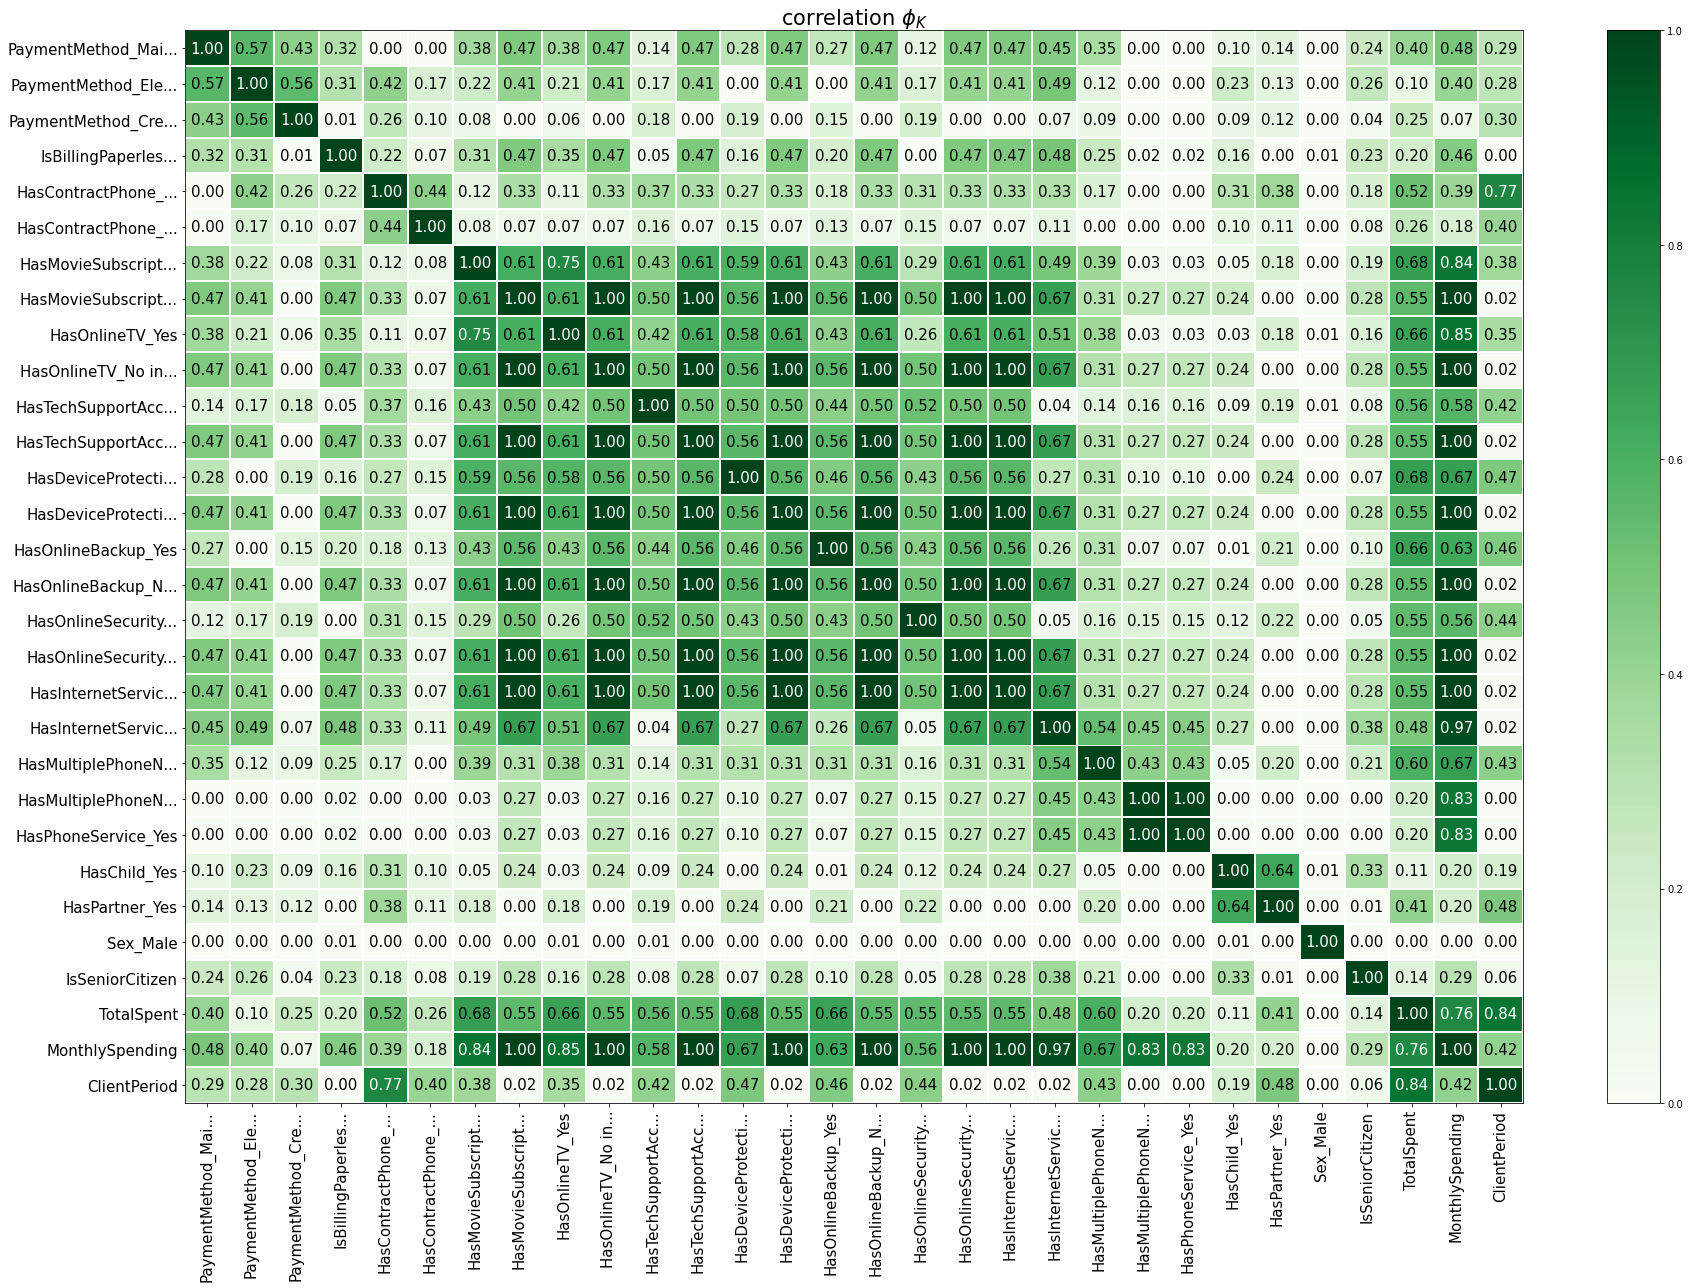

In [ ]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(26, 18))
plt.tight_layout()

In [ ]:
df.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen',
       'Churn', 'Sex_Male', 'HasPartner_Yes', 'HasChild_Yes',
       'HasPhoneService_Yes', 'HasMultiplePhoneNumbers_No phone service',
       'HasMultiplePhoneNumbers_Yes', 'HasInternetService_Fiber optic',
       'HasInternetService_No', 'HasOnlineSecurityService_No internet service',
       'HasOnlineSecurityService_Yes', 'HasOnlineBackup_No internet service',
       'HasOnlineBackup_Yes', 'HasDeviceProtection_No internet service',
       'HasDeviceProtection_Yes', 'HasTechSupportAccess_No internet service',
       'HasTechSupportAccess_Yes', 'HasOnlineTV_No internet service',
       'HasOnlineTV_Yes', 'HasMovieSubscription_No internet service',
       'HasMovieSubscription_Yes', 'HasContractPhone_One year',
       'HasContractPhone_Two year', 'IsBillingPaperless_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

Удалим столбцы с большой корреляцией. 

In [ ]:
df = df.drop(columns = ['HasTechSupportAccess_No internet service', 'HasPhoneService_Yes', 'HasOnlineTV_Yes',  
                        'HasOnlineTV_No internet service', 'HasOnlineSecurityService_Yes', 
                        'HasDeviceProtection_No internet service', 'HasOnlineBackup_No internet service',
                        'HasMultiplePhoneNumbers_Yes', 'HasInternetService_No', 
                        'HasDeviceProtection_Yes', 'HasMovieSubscription_No internet service', 'MonthlySpending'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientPeriod                                  5268 non-null   int64  
 1   TotalSpent                                    5268 non-null   float64
 2   IsSeniorCitizen                               5268 non-null   int64  
 3   Churn                                         5268 non-null   int64  
 4   Sex_Male                                      5268 non-null   uint8  
 5   HasPartner_Yes                                5268 non-null   uint8  
 6   HasChild_Yes                                  5268 non-null   uint8  
 7   HasMultiplePhoneNumbers_No phone service      5268 non-null   uint8  
 8   HasInternetService_Fiber optic                5268 non-null   uint8  
 9   HasOnlineSecurityService_No internet service  5268 non-null   u

In [ ]:
features = df.drop(['Churn'], axis=1)
target = df['Churn']

In [ ]:
interval_cols = ['TotalSpent','ClientPeriod'] #'MonthlySpending'
phik_overview = features.phik_matrix(interval_cols=interval_cols)

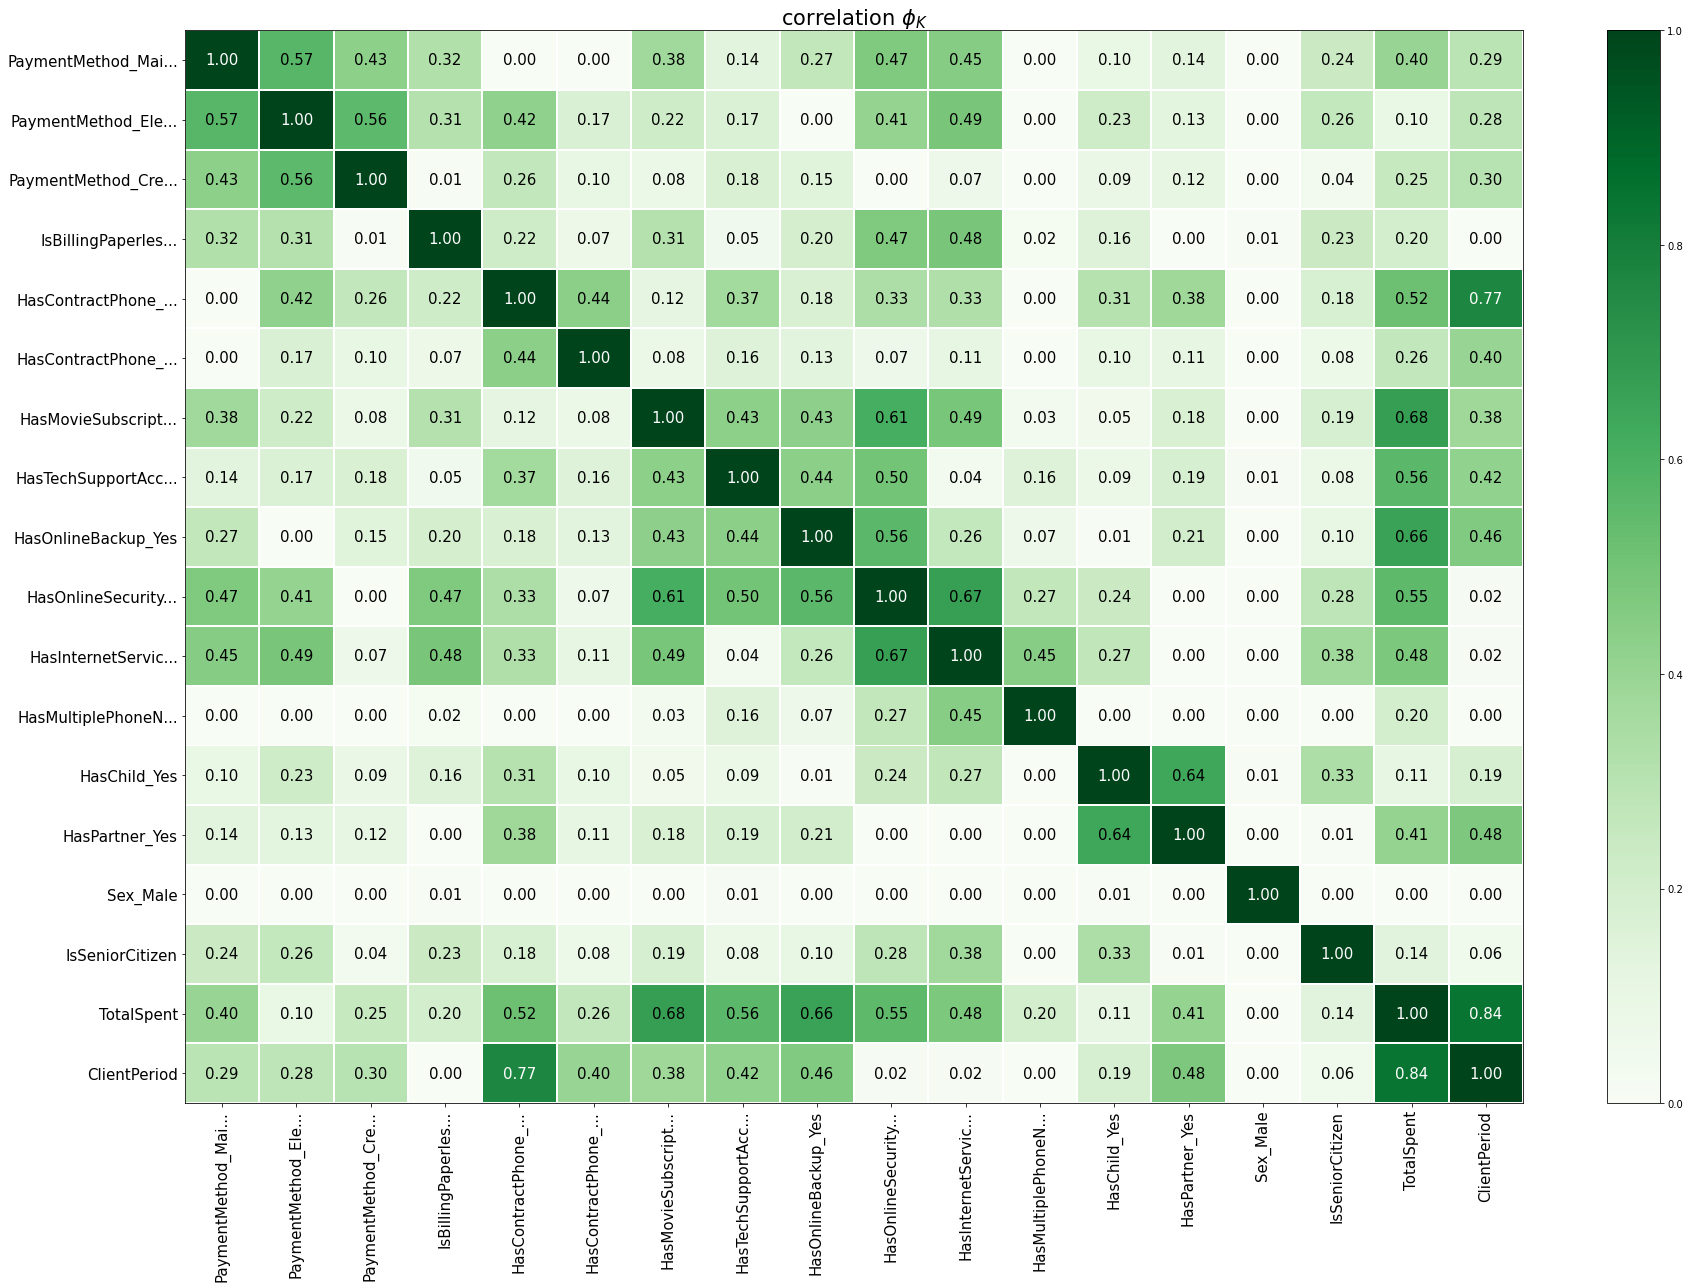

In [ ]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(26, 18))
plt.tight_layout()

## Разделение на обучающую и тестовую выборки

Разделим выборку на обучающую и тестовую для использования в общей функции в отношении 4:1 (def algorithm_pipeline_3)

In [ ]:
# создадим копии для последующего использования в pipeline
features_pipe = features.copy()
target_pipe = target.copy()

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)

Проверим корректность разделения исходных данных на выборки.

In [ ]:
features_train.shape, features_valid.shape, 

((4214, 18), (1054, 18))

Разделение выполнено корректно. 
Проверим баланс классов.

In [ ]:
features_valid

,ClientPeriod,TotalSpent,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasMultiplePhoneNumbers_No phone service,HasInternetService_Fiber optic,HasOnlineSecurityService_No internet service,HasOnlineBackup_Yes,HasTechSupportAccess_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4891,42,867.30,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1
121,3,107.25,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
2118,63,5029.05,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0
89,1,69.65,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1975,68,7508.55,0,0,1,1,0,1,0,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4729,50,4729.75,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
3501,18,1406.65,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0
1215,7,571.05,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0
1842,17,1214.05,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
target_train.mean(), target_valid.mean()

(0.260797342192691, 0.26091081593927895)

Баланс классов равный благодаря параметру stratify. Чего и следовало ожидать. 

## Масштабирование признаков

Нормируем отдельео разбитую на train/valid выборки и отдельно  исходные features

In [ ]:
numeric = ['TotalSpent','ClientPeriod']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid

,ClientPeriod,TotalSpent,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasMultiplePhoneNumbers_No phone service,HasInternetService_Fiber optic,HasOnlineSecurityService_No internet service,HasOnlineBackup_Yes,HasTechSupportAccess_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4891,0.391062,-0.622077,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1
121,-1.198115,-0.958944,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
2118,1.246773,1.222479,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0
89,-1.279611,-0.975609,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1975,1.450513,2.321435,0,0,1,1,0,1,0,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4729,0.717047,1.089825,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
3501,-0.586893,-0.383028,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0
1215,-1.035122,-0.753380,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0
1842,-0.627641,-0.468392,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
numeric = ['TotalSpent','ClientPeriod']
scaler = StandardScaler()
features[numeric] = scaler.fit_transform(features[numeric])
features

,ClientPeriod,TotalSpent,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasMultiplePhoneNumbers_No phone service,HasInternetService_Fiber optic,HasOnlineSecurityService_No internet service,HasOnlineBackup_Yes,HasTechSupportAccess_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.918149,-0.558463,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1
1,1.611260,-0.185661,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0
2,-1.283496,-0.977368,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
3,-0.019588,0.121889,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
4,1.122005,1.967919,0,0,1,1,0,1,0,1,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,-1.201954,-0.974613,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
5264,0.714293,-0.046276,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0
5265,-1.283496,-0.986557,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
5266,-0.141902,-0.034464,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0


# Обучение

## Логистическая регрессия

### LogisticRegression с cross_val_score

In [ ]:
cv = KFold(n_splits=5, shuffle = True, random_state = 12345)

best_score = 0

for C in [100, 10, 1, 0.1, 0.01, 0.001]:
    model = LogisticRegression(C=C, solver = 'saga', max_iter=10000)
    lr_best_score = cross_val_score(model, features, target,
                                scoring='roc_auc', cv=cv).mean().round(2)
        
    if lr_best_score.round(3) > best_score:
        best_score = lr_best_score.round(3)
    
    
print(f'ROC-AUC Логистической регрессии c cross_val_score: {best_score}')

ROC-AUC Логистической регрессии c cross_val_score: 0.84


### LogisticRegressionCV

In [ ]:
clf = LogisticRegressionCV(cv = 5, random_state= 12345, solver = 'saga', max_iter=10000, scoring='roc_auc', refit = True).fit(features_train,target_train)
clf.predict(features_valid)


scor = clf.score(features_train,target_train).round(3)

print(f'ROC-AUC LogisticRegressionCV: {scor}')

ROC-AUC LogisticRegressionCV: 0.84


### Pipeline+GridSearchCV

Возьмем исходные данные без кодирования и масштабирования, так как будем использовать это все в Pipeline.

In [ ]:
features = df_pipe.drop(['Churn'], axis=1)
target = df_pipe['Churn']
features

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check
5264,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic)
5265,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check
5266,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)


In [ ]:
def train_log_reg_pipeline():
        
    param_grid = {
        'logisticregression__penalty' : ['l1', 'l2', 'none'],
        'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
        'logisticregression__class_weight': ['balanced', None]
        }
    
    pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat_2', OneHotEncoder(sparse=False), cat_cols)
        ])

    cls = make_pipeline(pipeline,
                        LogisticRegression(random_state=12345, solver = 'saga', max_iter=10000)
                        )
    

    grid = GridSearchCV(estimator=cls, param_grid=param_grid,
                        cv=5, scoring='roc_auc', refit=True, n_jobs=-1)
    grid.fit(features, target)

    best = grid.best_estimator_

    #print(best)
    print(grid.best_params_)
    print(f'ROC-AUC LogisticRegression c Pipeline: {grid.best_score_.round(3)}')

In [ ]:
train_log_reg_pipeline()

{'logisticregression__C': 10, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}
ROC-AUC LogisticRegression c Pipeline: 0.845


Наилучшее качество ROC-AUC у LogisticRegression + GridSearchCV: 0.845

## Сatboost

Произведем разделение исходного датасета на трейн и валидационную выборку. 
Для Catboost также не будем использовать кодирование и масштабирование зараннее. Это все уже реализовано в самой модели. 

In [ ]:
features.head(3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check


In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)


Проверим корректность разделения исходных данных на выборки.

In [ ]:
features_train.shape, features_valid.shape,

((4214, 19), (1054, 19))

Разделение выполнено корректно. 
Проверим баланс классов.

In [ ]:
target_train.mean(), target_valid.mean()

(0.260797342192691, 0.26091081593927895)

### Catboost cо стандартными параметрами

Протестируем catboost cо стандартными параметрами

In [ ]:
model = CatBoostClassifier(cat_features=cat_cols, verbose=500).fit(features_train, target_train)
prediction = model.predict_proba(features_valid)[:, 1]
roc_auc_score(target_valid, prediction)

Learning rate set to 0.019041
0:	learn: 0.6811776	total: 65.2ms	remaining: 1m 5s
500:	learn: 0.3707921	total: 6.63s	remaining: 6.61s
999:	learn: 0.3287317	total: 14s	remaining: 0us


0.8585272493873264

### Catboost + GridSearchCV

Попробуем реализовать встроенный поиск гиперпараметров. 

In [ ]:
%%time

model = CatBoostClassifier(loss_function='Logloss', 
                               cat_features=cat_cols,
                               eval_metric = 'AUC', #:hints=skip_train~false
                               verbose=False)

grid = {'learning_rate': np.linspace(0.01, 0.2, 10),
        'depth': [3, 6],
        'l2_leaf_reg': [2, 5] 
        } #'n_estimators': [200, 300]

grid_search_result = model.grid_search(grid,
                                       X=features, 
                                       y=target,
                                       stratified = True,
                                       train_size = 0.8,
                                       cv=3,
                                       refit=True,
                                       verbose=500,
                                       plot=True)




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8628264675
bestIteration = 448

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8628265	best: 0.8628265 (0)	total: 7.5s	remaining: 4m 52s

bestTest = 0.8629244953
bestIteration = 258

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8619162096
bestIteration = 69

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8622733108
bestIteration = 51

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8634309721
bestIteration = 42

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8628824834
bestItera

In [ ]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 2, 'learning_rate': 0.1366666666666667}

In [ ]:
best_model = CatBoostClassifier(depth = grid_search_result['params']['depth'],
                                l2_leaf_reg = grid_search_result['params']['l2_leaf_reg'], 
                                learning_rate = grid_search_result['params']['learning_rate'],
                                eval_metric='AUC',
                                iterations=200,
                                loss_function= 'Logloss',
                                cat_features=cat_cols,
                                random_seed=12345,
                                verbose=200)
    
best_model.fit(features, target)

pred_train = best_model.predict_proba(features)[:,1]
roc_auc_score(target, pred_train)


0:	total: 17.8ms	remaining: 3.55s
199:	total: 3.24s	remaining: 0us


0.9034668908012851

In [ ]:
best_model.fit(features, target)

0:	total: 17.6ms	remaining: 3.5s
199:	total: 3.24s	remaining: 0us


In [ ]:
best_model.get_best_score()

{'learn': {'Logloss': 0.3128137133229449}}

Наилучшее качество получилось у модели LogisticRegression cо встроенным GridSearchCV: 0.85

# Предсказания

Загрузим и почистим тестовую выборку: удалим пробелы в столбце TotalSpent и изменим тип данных. 

In [ ]:
X_test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv', index_col = 0)

In [ ]:
X_test.replace(' ', 0, inplace=True)

In [ ]:
X_test.TotalSpent = X_test.TotalSpent.astype('float64')

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

Получим ответы модели на тестовой выборке. 

In [ ]:
submission['Churn'] = best_model.predict_proba(X_test)[:,1]


Загрузим ответы в submission и отправим на соревнование. 

In [ ]:
submission.to_csv('my_submission.csv')

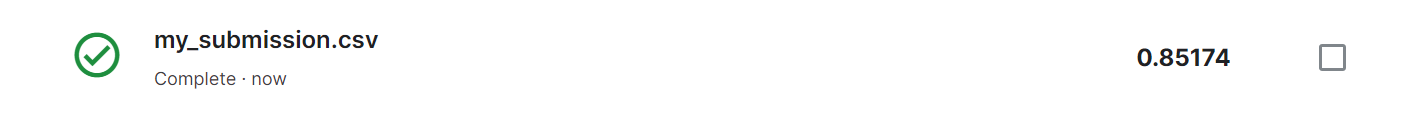

# Вывод

В результате на CatBoost с GridSearchCV удалось получить метрику выше, чем 0.85, а именно: 0.85174. 

В настоящем проекте были использованы такие модели, как LogisticRegression и CatBoost.
Можно отметить, что прирост качества не сильно высок, однако время работы моделей сильно разнится. 